# 推理与部署

[![下载Notebook](https://gitee.com/mindspore/docs/raw/tutorials-develop/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/tutorials-develop/tutorials/zh_cn/mindspore_infer.ipynb)&emsp;[![下载样例代码](https://gitee.com/mindspore/docs/raw/tutorials-develop/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/tutorials-develop/tutorials/zh_cn/mindspore_infer.py)&emsp;[![查看源文件](https://gitee.com/mindspore/docs/raw/tutorials-develop/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/tutorials-develop/tutorials/source_zh_cn/beginner/infer.ipynb)

本章使用MindSpore Vision中的`mobilenet_v2`网络微调的方法来开发一个AI应用，并将训练好的模型部署到手机侧来识别狗和牛角包。

## MobileNetV2模型简介

MobileNet网络是由Google团队于2017年提出的专注于移动端、嵌入式或IoT设备的轻量级CNN网络，相比于传统的卷积神经网络，MobileNet网络使用深度可分离卷积（Depthwise Separable Convolution）的思想在准确率小幅度降低的前提下，大大减小了模型参数与运算量；并引入宽度系数 $\alpha$ 和分辨率系数 $\beta$ 使模型满足不同应用场景的需求。由于MobileNet网络中Relu激活函数处理低维特征信息时会存在大量的丢失，所以MobileNetV2网络提出使用倒残差结构（Inverted residual block）和Linear Bottlenecks来设计网络，以提高模型的准确率，且优化后的模型更小。

![mobilenet](https://gitee.com/mindspore/docs/raw/tutorials-develop/tutorials/source_zh_cn/beginner/images/mobilenet.png)

图中Inverted residual block结构是先使用1x1卷积进行升维，然后使用3x3的DW卷积，最后使用1x1的卷积进行降维。与Residual block结构相反，Residual block是先使用1x1的卷积进行降维，然后使用3x3的卷积，最后使用1x1的卷积进行升维。

> [详细内容可参见MobileNetV2论文](https://arxiv.org/pdf/1801.04381.pdf)

## 模型训练

本案例使用预训练模型在狗和牛角包的小数据集上对模型进行微调，并将训练好的CKPT模型文件转换为MINDIR格式，用于后续手机侧的部署。

### 数据准备

+ 下载数据集

下载案例所用到的[狗与牛角包分类数据集](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/beginner/DogCroissants.zip)，该数据集有狗狗和牛角包两个类别，每个类有大约150张训练图像、20张验证图像和1张推理图像。下载示例如下。

In [39]:
import os
import requests
import zipfile

requests.packages.urllib3.disable_warnings()


def download_dataset(url, target_path):
    """下载并解压数据集"""
    if not os.path.exists(target_path):
        os.makedirs(target_path)
    download_file = url.split("/")[-1]
    if not os.path.exists(download_file):
        res = requests.get(url, stream=True, verify=False)
        if download_file.split(".")[-1] not in ["tgz", "zip", "tar", "gz"]:
            download_file = os.path.join(target_path, download_file)
        with open(download_file, "wb") as f:
            for chunk in res.iter_content(chunk_size=512):
                if chunk:
                    f.write(chunk)
    if download_file.endswith("zip"):
        z = zipfile.ZipFile(download_file, "r")
        z.extractall(path=target_path)
        z.close()
    print("The {} file is downloaded and saved in the path {} after processing".format(os.path.basename(url),
                                                                                       target_path))

download_dataset(
    "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/beginner/DogCroissants.zip",
    "./datasets")

The DogCroissants.zip file is downloaded and saved in the path ./datasets after processing


数据集的目录结构如下：

```text
datasets
└── DogCroissants
    ├── infer
    │   ├── croissants.jpg
    │   └── dog.jpg
    ├── train
    │   ├── croissants
    │   └── dog
    └── val
        ├── croissants
        └── dog
```

+ 下载预训练模型

下载案例所需的[MobileNetV2预训练模型的ckpt文件](https://download.mindspore.cn/vision/classification/mobilenet_v2_1.0_224.ckpt)，预训练模型的宽度系数$\alpha= 1.0$，输入图像大小为(224, 224), 将下载的预训练模型保存在当前目录下。

In [40]:
ckpt_path = "./mobilenet_v2_1.0_224.ckpt"
if not os.path.exists(ckpt_path):
    res = requests.get("https://download.mindspore.cn/vision/classification/mobilenet_v2_1.0_224.ckpt", stream=True,
                       verify=False)
    with open(ckpt_path, "wb") as f:
        for chunk in res.iter_content(chunk_size=512):
            if chunk:
                f.write(chunk)
    print("The file download success.")
else:
    print("The file already exists.")

The file already exists.


### 加载数据集

定义 `create_dataset`函数加载狗和牛角包数据集，对数据集进行图像增强操作并设置数据集batch_size大小。加载训练数据集和验证数据集用于后续的模型训练和验证。

In [41]:
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as transforms


def create_dataset(path, batch_size=10, train=True, image_size=224):
    dataset = ds.ImageFolderDataset(path, num_parallel_workers=8, class_indexing={"croissant": 0, "dog": 1})

    # 图像增强操作
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    if train:
        trans = [
            transforms.RandomCropDecodeResize(image_size, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            transforms.RandomHorizontalFlip(prob=0.5),
            transforms.Normalize(mean=mean, std=std),
            transforms.HWC2CHW()
        ]
    else:
        trans = [
            transforms.Decode(),
            transforms.Resize(256),
            transforms.CenterCrop(image_size),
            transforms.Normalize(mean=mean, std=std),
            transforms.HWC2CHW()
        ]
    dataset = dataset.map(operations=trans, input_columns="image", num_parallel_workers=8)
    # 设置batch_size的大小，若最后一次抓取的样本数小于batch_size，则丢弃
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset


# 加载训练数据集
train_path = "./datasets/DogCroissants/train"
dataset_train = create_dataset(train_path, train=True)

# 加载验证数据集
val_path = "./datasets/DogCroissants/val"
dataset_val = create_dataset(val_path, train=False)

### MobileNetV2模型微调

本章使用MobileNetV2的预训练模型进行微调，通过删除MobileNetV2预训练模型中最后一个用于分类的1x1的卷积层的参数，使用狗与牛角包数据集对模型进行重新训练以更新模型参数。

In [ ]:
import mindspore.nn as nn
from mindspore.train import Model
from mindspore import load_checkpoint, load_param_into_net
from mindvision.classification.models import mobilenet_v2
from mindvision.engine.loss import CrossEntropySmooth

# 创建模型,其中目标分类数为2，图像输入大小为(224,224)
network = mobilenet_v2(num_classes=2, resize=224)
# 模型参数存入到param_dict
param_dict = load_checkpoint("./mobilenet_v2_1.0_224.ckpt")

# 获取mobilenet_v2网络最后一个卷积层的参数名
filter_list = [x.name for x in network.head.classifier.get_parameters()]


# 删除预训练模型的最后一个卷积层
def filter_checkpoint_parameter_by_list(origin_dict, param_filter):
    for key in list(origin_dict.keys()):
        for name in param_filter:
            if name in key:
                print("Delete parameter from checkpoint: ", key)
                del origin_dict[key]
                break


filter_checkpoint_parameter_by_list(param_dict, filter_list)

# 加载预训练模型参数作为网络初始化权重
load_param_into_net(network, param_dict)

# 定义优化器
network_opt = nn.Momentum(params=network.trainable_params(), learning_rate=0.001, momentum=0.9)

# 定义损失函数
network_loss = CrossEntropySmooth(sparse=True, reduction="mean", smooth_factor=0.1, classes_num=2)

# 定义评价指标
metrics = {"Accuracy": nn.Accuracy()}

# 初始化模型
model = Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=metrics)

### 模型训练与评估

训练并评估网络，使用MindSpore Vision中的`mindvision.engine.callback.ValAccMonitor`接口打印训练的损失值和评估精度，且在训练完成后，保存评估精度最高的CKPT文件`best.ckpt`在当前目录下。

In [ ]:
import time
from mindvision.engine.callback import ValAccMonitor
from mindspore.train.callback import TimeMonitor

num_epochs = 10
start_time = time.time()
# 模型训练与验证，训练完成后保存验证精度最高的ckpt文件（best.ckpt）到当前目录下
model.train(num_epochs,
            dataset_train,
            dataset_sink_mode=False,
            callbacks=[ValAccMonitor(model, dataset_val, num_epochs), TimeMonitor()])
time = time.time() - start_time
print(f"Train time:{int(time):5d}s")

### 可视化模型预测

定义 `visualize_model` 函数，使用上述验证精度最高的模型对输入图像进行预测，并将预测结果可视化。

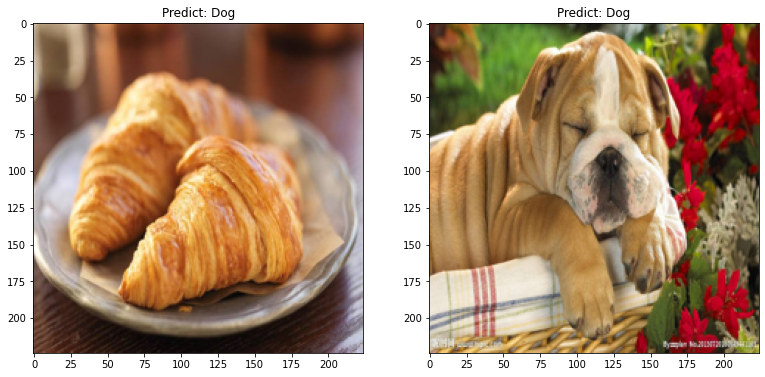

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from mindspore import Tensor


def visualize_model(path):
    # 加载图片
    image = Image.open(path).convert("RGB")
    # resize图片大小为（224,224)
    image = image.resize((224, 224))

    plt.imshow(image)

    # 归一化处理
    mean = np.array([0.485 * 255, 0.456 * 255, 0.406 * 255])
    std = np.array([0.229 * 255, 0.224 * 255, 0.225 * 255])
    image = np.array(image)
    image = (image - mean) / std
    image = image.astype(np.float32)
    # 图像通道由(h, w, c)转换为(c, h, w)
    image = np.transpose(image, (2, 0, 1))
    # 扩展数据维数为（1，c, h, w）
    image = np.expand_dims(image, axis=0)

    # 定义并加载网络
    net = mobilenet_v2(num_classes=2, resize=224)
    param_dict = load_checkpoint("./best.ckpt")
    load_param_into_net(net, param_dict)
    model = Model(net)
    # 模型预测
    pre = model.predict(Tensor(image))
    result = np.argmax(pre)

    class_name = {0: "Croissant", 1: "Dog"}
    plt.title(f"Predict: {class_name[result]}")
    return result


path1 = "./datasets/DogCroissants/infer/croissants.jpg"
plt.figure(figsize=(13, 7))
plt.subplot(1, 2, 1)
visualize_model(path1)

path2 = "./datasets/DogCroissants/infer/dog.jpg"
plt.subplot(1, 2, 2)
visualize_model(path2)
plt.show()

### 转换MINDIR文件格式

训练完成后将CKPT文件转换为MINDIR格式，用于后续手机侧的推理，在当前目录下会生成`mobilenet_v2_1.0_224.mindir`文件。

In [38]:
from mindspore import export, Tensor

# 定义并加载网络参数
net = mobilenet_v2(num_classes=2, resize=224)
param_dict = load_checkpoint("best.ckpt")
load_param_into_net(net, param_dict)

# 将模型由ckpt格式导出为MINDIR格式
input_np = np.random.uniform(0.0, 1.0, size=[1, 3, 224, 224]).astype(np.float32)
export(net, Tensor(input_np), file_name="mobilenet_v2_1.0_224", file_format="MINDIR")
print("Export MINDIR file success.")

Export MINDIR file success.


## 手机侧推理与部署

为实现模型文件在手机侧的推理功能，首先需要要将MINDIR模型文件转换成手机侧可识别的ms模型文件；然后在手机侧部署应用，即下载一个Android APK应用；最后将ms模型文件导入到手机侧后，可以体验狗与牛角包的识别功能。

### 转换文件格式

使用转换工具[MindSpore Lite Converter](https://www.mindspore.cn/lite/docs/zh-CN/master/use/converter_tool.html)将上述生成的mobilenet_v2_1.0_224.mindir文件转换为手机端可识别的mobilenet_v2_1.0_224.ms文件。

+ Linux下使用MindSpore Lite Converter转换文件格式，[Linux-x86_64下工具下载链接](https://ms-release.obs.cn-north-4.myhuaweicloud.com/1.6.0/MindSpore/lite/release/linux/x86_64/mindspore-lite-1.6.0-linux-x64.tar.gz)。

```text
# 设置软件包的路径，PACKAGE_ROOT_PATH为MindSpore Lite Converter工具包的路径
export PACKAGE_ROOT_PATH=./path

# 将转换工具需要的动态链接库加入到环境变量LD_LIBRARY_PATH
export LD_LIBRARY_PATH=${PACKAGE_ROOT_PATH}/tools/converter/lib:${LD_LIBRARY_PATH}

# 在mindspore-lite-1.6.0-linux-x64/tools/converter/converter执行转换命令
./converter_lite --fmk=MINDIR --modelFile=mobilenet_v2_1.0_224.mindir  --outputFile=mobilenet_v2_1.0_224
```

+ Windows下使用MindSpore Lite Converter转换文件格式，[Windows-x64下工具下载链接](https://ms-release.obs.cn-north-4.myhuaweicloud.com/1.6.0/MindSpore/lite/release/windows/mindspore-lite-1.6.0-win-x64.zip)。

```text
# 设置软件包的安装路径，path为MindSpore Lite Converter工具包的路径
set PACKAGE_ROOT_PATH=path

# 将转换工具需要的动态链接库加入到环境变量PATH
set PATH=%PACKAGE_ROOT_PATH%\tools\converter\lib;%PATH%

# 在mindspore-lite-1.6.0-win-x64\tools\converter\converter路径下执行转换命令
call converter_lite --fmk=MINDIR --modelFile=mobilenet_v2_1.0_224.mindir --outputFile=mobilenet_v2_1.0_224
```

转换成功后打印`CONVERT RESULT SUCCESS:0`，且在当前目录下生成`mobilenet_v2_1.0_224.ms`文件。

> 其他环境下载MindSpore Lite Converter参见[下载MindSpore Lite-推理](https://www.mindspore.cn/lite/docs/zh-CN/master/use/downloads.html)。

### 部署应用

使用手机浏览器（由于微信限制，不支持微信扫描）扫描二维码或直接下载APK文件，并部署到Android设备后使用。APK应用名称显示为PetClassification。

![classification](https://gitee.com/mindspore/docs/raw/tutorials-develop/tutorials/source_zh_cn/beginner/images/classification_APP.png)

APP支持的功能如下：

+ 图片：选择相册中的照片识别；
+ 相机：打开相机拍照识别；
+ 预览：打开摄像头扫描识别：
+ 选择一个案例：选择案例中的任意一张图片识别。

### 识别狗与牛角包

为实现手机端狗与牛角包的识别功能，需将mobilenet_v2_1.0_224.ms文件放置到手机对应的应用包 <font color=#FF8C00>Android/data/com.mindspore.classificationforpet/files</font> 文件夹下。放置好后，可打开APP应用，体验狗与牛角包的识别功能。

> 本章仅包含手机侧简单的部署过程，想要了解推理更多内容请参考[MindSpore Lite](https://www.mindspore.cn/lite/docs/zh-CN/master/index.html)。